In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns, numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib as mpl
import io
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import label_binarize,LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_olivetti_faces
from sklearn import svm, datasets
from sklearn import clone
from scipy import stats
from scipy import special, optimize

- overall : 감시취약면적, 감시취약지수(cctv_idx), 격자가중치w1 가 있다
- w2 : 행정동별 단독주택
- w3 : 행정동별 여성주가구비율

## w2-3의 데이터 출처
https://data.seoul.go.kr/dataList/10595/S/2/datasetView.do

https://data.seoul.go.kr/dataList/10585/S/2/datasetView.do

## 목표
- 아래 지수에 대한 scoring 을 위한 정규화
- 정규화 후 상관계수 출력
- 동 별 분류 모델링
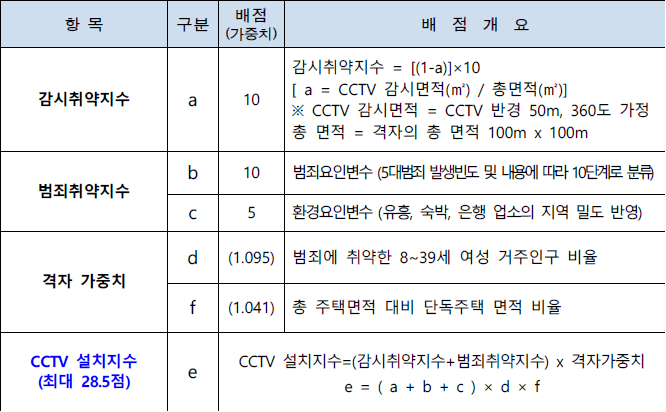

# 최종 테이블
- 2020/12/14 11:40 - overall_merge_w1

## Grade2_env = (유흥밀도+숙박밀도_금융밀도)*5 으로써 1~10사이의 값을가짐.

In [2]:
overall = pd.read_csv('행정동_OVERALL(cctv_by_emd-idx,v1,v2,w1)_1208.csv')

In [5]:
w2 = pd.read_csv('행정동별_단독주택_w2.csv')

In [6]:
w3 = pd.read_csv('행정동별_여성주가구비율_w3.csv')

In [3]:
overall.head(5)

,BASE_YEAR,ADM_DR_CD,ADM_DR_NM,cctv_area,cctv_idx,금융업소갯,숙박업소갯,유흥업소갯,max뉴연번,grade1_cri,...,val_29,val_19,val_16,val_39,sum_women,w1,가중치_w1(w1*3),.75 이상이면 1.095 이하면 1,w1_women,count_1
0,2018,1115051,목1동,193887,8.061,11,3,103,13599,4,...,126,52,77,192,602,0.25341,0.76023,1.095,1.095,179
1,2018,1115052,목2동,531772,4.682,3,2,23,13600,4,...,85,31,40,81,221,0.39560,1.18680,1.095,1.095,133
2,2018,1115053,목3동,329554,6.704,3,1,40,13604,4,...,65,14,12,145,221,0.40000,1.20000,1.095,1.095,80
3,2018,1115054,목4동,377440,6.226,2,0,30,13607,4,...,93,33,40,56,237,0.34247,1.02741,1.095,1.095,82
4,2018,1115057,신월1동,349643,6.504,2,1,46,13601,4,...,38,11,10,45,93,0.28497,0.85491,1.095,1.095,88


In [7]:
w2.head(1)

,기간,자치구,동,합계,주택합계,단독주택,단독주택 전처리 (전체단독주택수 : 행정동 단독주택수 = 전체합계 : 행정동 전체합계),w2,다가구주택,영업겸용,아파트,연립주택,다세대주택,비거주용건물내주택
0,2015,양천구,목1동,7769,127,17,"1,438(F2)*127(E3) / 9907(E2)",NaN,74,36,"7,370",42,197,33


In [8]:
w3.head(3)

,기간,자치구,동,일반가구,여성가구주 가구,여성가구주가구비율,value*(3/100),0.7 이상이면 1.041 이하면 1
0,2010,양천구,소계,"154,239","36,561",23.7,0.711,1.041
1,2010,양천구,목1동,"9,463","1,557",16.5,0.495,1.000
2,2010,양천구,목2동,"9,934","2,547",25.6,0.768,1.041


In [9]:
# merge 하기 위해 column 이름 변경 overall의 행정동 이름 변경 
overall.rename(columns= {'ADM_DR_NM' : '행정동'},inplace = True)
w2.rename(columns= {'동' : '행정동'},inplace = True)
w3.rename(columns= {'동' : '행정동'},inplace = True)

In [17]:
overall[('행정동')][1]

'목2동'

In [18]:
w2[('행정동')][1]

'목2동'

In [19]:
w3[('행정동')][1]

'목1동'

In [25]:
overall_merge = pd.merge(overall,w2,on = ['행정동'])

In [26]:
overall_merge = pd.merge(overall_merge,w3, on = ['행정동'])

In [86]:
overall_merge[1:5]

,BASE_YEAR,ADM_DR_CD,행정동,cctv_area,a,금융업소갯,숙박업소갯,유흥업소갯,max뉴연번,b,...,연립주택,다세대주택,비거주용건물내주택,기간_y,자치구_y,일반가구,여성가구주 가구,여성가구주가구비율,value*(3/100),0.7 이상이면 1.041 이하면 1
1,2018,1115052,목2동,531772,4.682,3,2,23,13600,4,...,514,"5,398",75,2010,양천구,"9,934","2,547",25.6,0.768,1.041
2,2018,1115053,목3동,329554,6.704,3,1,40,13604,4,...,141,"3,227",49,2010,양천구,"7,466","2,182",29.2,0.876,1.041
3,2018,1115054,목4동,377440,6.226,2,0,30,13607,4,...,300,"3,096",79,2010,양천구,"8,445","2,008",23.8,0.714,1.041
4,2018,1115057,신월1동,349643,6.504,2,1,46,13601,4,...,443,"2,662",107,2010,양천구,"8,574","2,351",27.4,0.822,1.041


In [48]:
overall_merge.columns

Index(['BASE_YEAR', 'ADM_DR_CD', '행정동', 'cctv_area', 'cctv_idx', '금융업소갯',
       '숙박업소갯', '유흥업소갯', 'max뉴연번', 'grade1_cri', 'maxX', 'maxY', 'count',
       'NUMPOINT', '금융밀도', '숙박밀도', '유흥밀도', 'grade2_env', 'val_200', 'val_13',
       'val_29', 'val_19', 'val_16', 'val_39', 'sum_women', 'w1',
       '가중치_w1(w1*3)', '.75 이상이면 1.095 이하면 1', 'w1_women', 'count_1', '기간_x',
       '자치구_x', '합계', '주택합계', '단독주택',
       '단독주택 전처리 (전체단독주택수 : 행정동 단독주택수 = 전체합계 : 행정동 전체합계)', 'w2', '다가구주택',
       '영업겸용', '아파트', '연립주택', '다세대주택', '비거주용건물내주택', '기간_y', '자치구_y', '일반가구',
       '여성가구주 가구', '여성가구주가구비율', 'value*(3/100)', '0.7 이상이면 1.041 이하면 1'],
      dtype='object')

- 감시취약지수 : a
- 범죄취약지수 - 범죄요인변수 : b
- 범죄취약지수 - 환경요인변수 : c

In [50]:
overall_merge.rename(columns = {'cctv_idx' : 'a'},inplace = True)
overall_merge.rename(columns = {'grade1_cri' : 'b'},inplace = True)
overall_merge.rename(columns = {'유흥밀도' : 'c'},inplace = True)

In [59]:
overall_merge['a'][0:5]

0    8.061
1    4.682
2    6.704
3    6.226
4    6.504
Name: a, dtype: float64

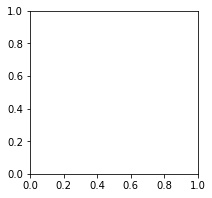

In [45]:
df = overall_merge.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots(figsize=(3,3))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [31]:
sns.heatmap(overall_merge, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

ValueError: Mask must have the same shape as data.

In [60]:
# w1에 대한 정규화를 진행할 것임.
mnscaler = MinMaxScaler()

In [64]:
df1 = pd.DataFrame(overall_merge.loc[:,'행정동'], columns = ['행정동'])

In [67]:
df2 = pd.DataFrame(mnscaler.fit_transform(overall_merge.loc[:, 'sum_women':'w1']), columns = ['sum_women','w1'])

In [69]:
w1_df = df1 = pd.DataFrame(overall_merge.loc[:,'w1'], columns = ['w1'])

In [70]:
w1_df

,w1
0,0.25341
1,0.39560
2,0.40000
3,0.34247
4,0.28497
5,0.43697
6,0.28497
7,0.20000
8,0.22872
9,0.22439


- Min Max 를 사용한 정규화

In [68]:
overall_merge_scaling = pd.concat([df1,df2],axis=1)
print(overall_merge_scaling)

     행정동  sum_women        w1
0    목1동   1.000000  0.178033
1    목2동   0.251473  0.652000
2    목3동   0.251473  0.666667
3    목4동   0.282908  0.474900
4   신월1동   0.000000  0.283233
5   신월2동   0.153242  0.789900
6   신월3동   0.015717  0.283233
7   신월4동   0.155206  0.000000
8   신월5동   0.041257  0.095733
9   신월6동   0.271120  0.081300
10  신월7동   0.163065  0.070367
11  신정1동   0.223969  0.248833
12  신정2동   0.223969  0.163433
13  신정3동   0.367387  0.789900
14  신정6동   0.298625  0.158567
15  신정7동   0.212181  0.201033
16   목5동   0.253438  1.000000
17  신정4동   0.078585  0.789900


- Z_score 정규화(소수점까지나와서)

In [71]:
from sklearn.preprocessing import StandardScaler

In [73]:
overall_merge_z = overall_merge
stdscaler = StandardScaler()

In [74]:
df1 = pd.DataFrame(overall_merge.loc[:,'행정동'], columns = ['행정동'])
df2 = pd.DataFrame(stdscaler.fit_transform(overall_merge.loc[:, 'sum_women':'w1']), columns = ['sum_women','w1'])

In [75]:
overall_merge_stdscaling = pd.concat([df1,df2],axis=1)
print(overall_merge_stdscaling)

     행정동  sum_women        w1
0    목1동   3.635197 -0.679310
1    목2동   0.074760  0.877593
2    목3동   0.074760  0.925770
3    목4동   0.224279  0.295848
4   신월1동  -1.121397 -0.333745
5   신월2동  -0.392489  1.330571
6   신월3동  -1.046638 -0.333745
7   신월4동  -0.383144 -1.264120
8   신월5동  -0.925153 -0.949652
9   신월6동   0.168210 -0.997063
10  신월7동  -0.345764 -1.032977
11  신정1동  -0.056070 -0.446744
12  신정2동  -0.056070 -0.727269
13  신정3동   0.626114  1.330571
14  신정6동   0.299039 -0.743255
15  신정7동  -0.112140 -0.603759
16   목5동   0.084105  2.020715
17  신정4동  -0.747598  1.330571


## 정규화는 MinMax 정규화를 채택한다
- min max 1~0 사이의 값의 중간은 0.5 이므로
- 0.5 이상이면 1.095 이하면 1

In [85]:
overall_merge_scaling[1:19]

,행정동,sum_women,w1
1,목2동,0.251473,0.652000
2,목3동,0.251473,0.666667
3,목4동,0.282908,0.474900
4,신월1동,0.000000,0.283233
5,신월2동,0.153242,0.789900
6,신월3동,0.015717,0.283233
7,신월4동,0.155206,0.000000
8,신월5동,0.041257,0.095733
9,신월6동,0.271120,0.081300
10,신월7동,0.163065,0.070367


In [88]:
overall_merge_scaling.rename(columns = {'w1':'w1_mn'},inplace = True)

In [91]:
overall_merge_scaling[1:2]

,행정동,sum_women,w1_mn
1,목2동,0.251473,0.652


In [95]:
np.where[overall_merge_scaling['w1_mn'] > 0.5]

TypeError: 'function' object is not subscriptable

In [98]:
overall_merge_scaling['w1_score'] = np.where(overall_merge_scaling['w1_mn'] > 0.5,1.091,1)

In [99]:
overall_merge_scaling

,행정동,sum_women,w1_mn,w1_score
0,목1동,1.000000,0.178033,1.000
1,목2동,0.251473,0.652000,1.091
2,목3동,0.251473,0.666667,1.091
3,목4동,0.282908,0.474900,1.000
4,신월1동,0.000000,0.283233,1.000
5,신월2동,0.153242,0.789900,1.091
6,신월3동,0.015717,0.283233,1.000
7,신월4동,0.155206,0.000000,1.000
8,신월5동,0.041257,0.095733,1.000
9,신월6동,0.271120,0.081300,1.000


In [100]:
overall_merge_w1 = pd.merge(overall_merge,overall_merge_scaling, on = ['행정동'])

- 행정동 까지 하고 전체데이터 merge 하였음.
- w2,w3 동일하게 scaling 